# Machine Learning Basis and Classification

In [1]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## Loading MNIST

In this lab, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST. Whenever someone learns Machine Learning, sooner or later they tackle MNIST.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

print(digits.data.shape)

(1797, 64)


In [3]:
X_digits = digits.data
y_digits = digits.target

n_samples = len(X_digits)

X_train = X_digits[:round(.9 * n_samples)]
y_train = y_digits[:round(.9 * n_samples)]
X_test = X_digits[round(.9 * n_samples):]
y_test = y_digits[round(.9 * n_samples):]

## KNN classifier


Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task. Now let’s train the classifier:

In [4]:
from sklearn.neighbors import KNeighborsClassifier


y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train_5)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [5]:
some_digit = X_digits[1719]
knn_clf.predict([some_digit])

array([False])

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available, so grab another coffee and get ready to learn many new concepts and acronyms!

A good way to evaluate a model is to use cross-validation. Let’s use the cross_val_score() function to evaluate your KNN model using K-fold cross-validation, with three folds. Remember that K-fold crossvalidation means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

### Measuring Accuracy Using Cross-Validation

In [6]:
from sklearn.model_selection import cross_val_score

cross_val_score(knn_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9962963 , 0.99443414, 0.99628253])

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5 th row and 3 rd column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function. Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).


Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [7]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(knn_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[1452,    1],
       [   6,  158]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 1,452 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1 was wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 6 were wrongly classified as non-5s (false negatives), while the remaining 158 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [8]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[1453,    0],
       [   0,  164]], dtype=int64)

### Precision and Recall

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier:

\begin{equation} 
precision = \frac{TP}{TP+FP}
\end{equation}

TP is the number of true positives, and FP is the number of false positives.

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the classifier would ignore all but one positive instance. So precision is typically used along with another metric named recall, also called sensitivity or true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier:

\begin{equation} 
recall = \frac{TP}{TP+FN}
\end{equation}

FN is of course the number of false negatives.


In [9]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.9937106918238994

In [10]:
recall_score(y_train_5, y_train_pred)

0.9634146341463414

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

\begin{equation} 
recall = 2 \times \frac{precision \times recall}{precision+recall}
\end{equation}



In [11]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.978328173374613

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff.

### ROC curves

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity.

To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function:

In [12]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

In [13]:
from sklearn.model_selection import cross_val_predict
y_probas_knn = cross_val_predict(knn_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [14]:
from sklearn.metrics import roc_curve
y_scores_knn = y_probas_knn[:, 1] # score = proba of positive class
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train_5,y_scores_knn)

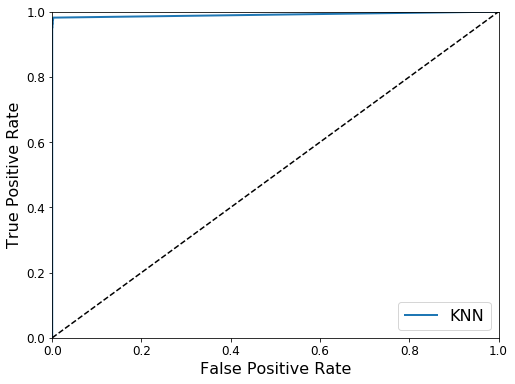

In [15]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_knn, tpr_knn, "KNN")
plt.legend(loc="lower right", fontsize=16)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [16]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores_knn)

0.9907592365669011

## Multiclass classification

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [18]:
y_knn_pred = knn_clf.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9722222222222222

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[161,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 154,   1,   0,   3,   0,   0,   0,   4,   1],
       [  1,   1, 149,   2,   0,   0,   0,   0,   7,   0],
       [  0,   0,   0, 159,   0,   0,   0,   3,   2,   1],
       [  0,   1,   0,   0, 158,   0,   0,   1,   0,   1],
       [  0,   0,   0,   0,   1, 158,   1,   0,   0,   4],
       [  1,   0,   0,   0,   0,   0, 161,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0, 160,   0,   0],
       [  0,   8,   1,   1,   0,   0,   0,   0, 147,   0],
       [  0,   3,   0,   2,   0,   1,   0,   5,   2, 149]], dtype=int64)

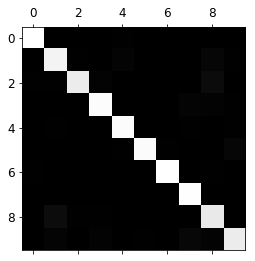

In [21]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

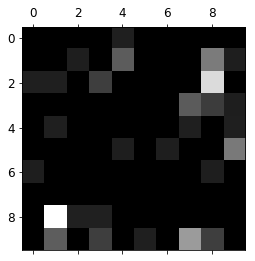

In [22]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Exercises

**Task 1**: Try to use the different *folds* of K-fold cross-validation to evaluate your KNN model.

In [23]:
# change the "cv" parameter in the cross_val_predict function

**Task 2**: Try to use the different *n_neighbors* of KNN for the MNIST dataset and then evaluate them (try  Confusion Matrix,  Precision,  Recall and ROC Curves). You can try to plot multiple ROC Curves into one figure (Hints: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).



In [24]:
# change "n_neighbors" in KNeighborsClassifier

**Task 3**: A more challenging exercise: Try to choose optimal value of *n_neighbors* of KNN with the help of cross validation.

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
hyper_parameters = [{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

In [27]:
clf = GridSearchCV(KNeighborsClassifier(), hyper_parameters, scoring='accuracy', cv=5)

In [28]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [29]:
clf.best_params_

{'n_neighbors': 3}